<a href="https://colab.research.google.com/github/marcinwolter/Tracking_student2020/blob/master/GNN_MuonE_v1_Robust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: GNNs for Particle Tracking

HEP.TrkX group

Steve Farrell, Daniel Murname

*Feb 2020*

Adapted for MuonE tracking by Marcin Wolter

*July 2020*

In [146]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [147]:
print("PyTorch version:",print(torch.__version__),", CUDA version:", torch.version.cuda)

1.5.1+cu101
PyTorch version: None , CUDA version: 10.1


In [ ]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

In [149]:
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_scatter import scatter_add
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
from IPython.display import HTML, display

%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## The Problem

The complexity of the graph depends on the angle cut we put on it. Try increasing max_angle to, say, `(5/6)*np.pi` and the graph should be more busy. The limit is of course `(6/6)*np.pi = pi` where each node will look at the full angle of available possible nodes to form an edge with. While playing with this number, run the next cell to see the proportion of fake edges to true edges (fake/true) on the above graph. This value will be extremely useful later.

## A Simple GNN

### Message Passing GNN

We can write out the full GNN as a class `MPNN_Network`. One can see its behaviour as:
1. Encode (x,y) features as hidden features with an N-layer MLP called `node_encoder`
2. Concatenate these along each edge, and feed the concatenated features into another MLP called `edge_network`
3. Sum the output of `edge_classifier` at each node (that is, each node receives the sum of the "messages" of all connecting edges). This sum is fed into `node_network`
4. Add the hidden features to the previous iteration (this helps to preserve information between messages)
5. Repeat (2) --> (4) n_graph_iters times
6. After the message passing loop, pass the features of each edge through an output classifier network called `edge_classifier`

In [250]:
def make_mlp(input_size, sizes,
             hidden_activation='ReLU',
             output_activation='ReLU',
             layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""

    hidden_activation = getattr(nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(nn, output_activation)
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers

    for i in range(n_layers-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[i+1]))
        layers.append(hidden_activation())

    # Final layer
    layers.append(nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return nn.Sequential(*layers)

class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True,normalize_factor= 1):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)
        self.normalize_factor=normalize_factor
    def forward(self, data):
        # Make every edge bi-directional
        send_idx = torch.cat([data.edge_index[0], data.edge_index[1]], dim=0)
        recv_idx = torch.cat([data.edge_index[1], data.edge_index[0]], dim=0)
        
        # Encode the graph features into the hidden space
        #print( torch.mean (data.x[:,0]) )
        #print( torch.mean (data.x[:,1]) )
        if self.normalize_factor!=1:
          temp = data.x
          temp[:,1]*= self.normalize_factor
          x = self.node_encoder(temp)
        else:
          x = self.node_encoder(data.x)
        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[send_idx], x[recv_idx]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, recv_idx, dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = data.edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)

Build a version of the model and print it out.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
m_configs = {"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 1, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)
model

### Training and Validation Functions


In [227]:
def train(model, train_loader, optimizer):
    correct = 0
    total = 0
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

def evaluate(model, test_loader):
    correct = 0
    total = 0
    total_loss = 0
    for batch in test_loader:
        data = batch.to(device)
        pred = model(data)
        loss = F.binary_cross_entropy_with_logits(pred.float(), data.y.float(), pos_weight=torch.tensor(weight))
        total_loss += loss.item()
        correct += ((pred > 0.5) == (data.y > 0.5)).sum().item()
        total += len(pred)
    acc = correct/total
    return acc, total_loss

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

### Did it work?

Running the above with 1 graph iteration gives me about 90% accuracy in 200 epochs.

The best performance that I can get with some simple manual tuning is around 95% accuracy. We can improve the efficiency at the cost of purity by raising the weight on true edges, but the accuracy won't significantly improve. In general, the biggest changes were from increasing the width (i.e. the number of dimensions) of the hidden layers. We can visualise the performance on a particular graph, colouring true positives black, false positives red, true negatives a transparent black, and false negatives in blue.

In [153]:
def plot_toy_classified(event, preds, cut=0.5):
    
    #print("New event")
        
    #print(event)
    #print(event.x)
    #print(event.pid)
    #print(event.y)
    #gprint(preds)

    plt.figure(figsize=(10,5))
    x, y = event.x[:,0].numpy(), event.x[:,1].numpy()
    edges = event.edge_index.numpy()
    labels = event.y
    plt.scatter(x, y, c='k')
    
    preds = preds.detach().numpy()
    

    for j in range(len(labels)):
        
        #print(str('%01.2f' % preds[j])+" "+str(labels[j].item())+" "+str(x[edges[0,j]]*feature_scale)+","+str(y[edges[0,j]]*feature_scale)+" "+str(x[edges[1,j]]*feature_scale)+","+str(y[edges[1,j]]*feature_scale))
        s = str('%01.2f' % preds[j])+" "+str(labels[j].item())
        plt.text((x[edges[0,j]]+x[edges[1,j]])/2., (y[edges[0,j]]+y[edges[1,j]])/2.+np.random.random(1)*0.00, s, fontsize=12)

        # False negatives
        if preds[j] < cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '--', c='b')

        # False positives
        if preds[j] > cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='r', alpha=preds[j])

        # True positives
        if preds[j] > cut and labels[j].item() > cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])
                
        # True negatives
        if preds[j] < cut and labels[j].item() < cut:
            plt.plot([x[edges[0,j]], x[edges[1,j]]],
                     [y[edges[0,j]], y[edges[1,j]]],
                     '-', c='k', alpha=preds[j])

So we can see that it's working quite well. Few missed true edges, and few misclassified fake edges. The ratio of false positives to false negatives (which can be defined with efficiency and purity) is controlled by the cut we put on the prediction score. 

### The effect of Message Passing

In this simple example, the message passing does not do a huge amount. Going from 1 iteration to 6 iterations improves the accuracy to around 93% (from 90%). This improvement is washed out with more hidden dimensions, as one can see from the below set of tests. Try playing with more hidden node and edge dimensions (e.g. 64) and see if the message passing iterations can improve the performance.



# **Load MuonE data and reconstruct tracks**

In [154]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
# Circle parameters
num_layers = 14
height, width = 10, 10
#min_curve, max_curve =  1000, 1001 # 15, 50

max_angle = (0.05)*np.pi
feature_scale = 200.

In [156]:
import numpy as np
import pandas as pd

def readMuonE():

   event_file = "/content/drive/My Drive/hitFile_medium.csv"

   data = pd.read_csv(event_file) 
   # Preview the first 5 lines of the loaded data 
   data.head()

   # Temporary nextZ  (next layer Z)
   layerZ0 =  [-999, -16, -21, 131, 151, 477, 497, 832, 843.7, 1146, 1141, 1252.7, 1266, 1973, 1960 ]



   #X = np.array([[0,0,0]])
   #print(X)
   
   
   iEventLast=data.iat[0,0]
   k=0
   Xcreated=False
   #dataOUTcreated=False
   dataOUT = []

   #iterate over input data
   for k, row in data.iterrows():
     ll=data.iat[k,0]
     #print("counter ",k,ll,iEventLast)
     if ll != iEventLast:

       '''
       for layer in np.arange(num_layers-1):
          print("XX=",layer,X)
          for i in np.argwhere(X[:,2] == layerZ0[layer+1]): 
            for j in np.argwhere(X[:,2] == layerZ0[layer+3]):
               if (X[i, 0] - 20. < X[j, 0] < X[i, 0] + 20.):
                   print("layer, i, j=",layer, i, j)
       '''
#       e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == layer+1) for j in np.argwhere(X[:,2] == (layer+2))  if (X[i, 0] - np.tan(max_angle/2) < X[j, 0] < X[i, 0] + np.tan(max_angle/2))]).T.squeeze()

       e = np.array([[i,j] for layer in np.arange(num_layers-1) for i in np.argwhere(X[:,2] == 
              layerZ0[layer+1]) for j in np.argwhere(X[:,2] == layerZ0[layer+3])  if (X[i, 0] - np.tan(max_angle/2)*(layerZ0[layer+3]-layerZ0[layer+1]) < X[j, 0] < X[i, 0] + np.tan(max_angle/2)*(layerZ0[layer+3]-layerZ0[layer+1]))]).T.squeeze()

       #print(X)
       #print("e ",e) 
        # This handles when no edges were constructed. In that case, the randomisation is a do-over
       #try:
       y = np.array([int(i[1] == j[1]) for i,j in zip(X[e[0]], X[e[1]])])
       #     print("y = ",y)     
       #     break
       #except:
       #     pass

       #print("y = ",y) 
       #if iter is not None and num_samples is not None:
       #     out.update(progress(iter, num_samples))    


       X = np.array([X[:,2], X[:,0]]).T / feature_scale

       dataEvent = Data(x = torch.from_numpy(X).float(), edge_index = torch.from_numpy(e), y = torch.from_numpy(y), pid = torch.from_numpy(X[:,1])  )

       #plot_toy_graph(dataEvent, 0.2)

       dataOUT.append(dataEvent)
#       if dataOUTcreated:
#         dataOUT = dataOUT.append(dataEvent)
#       else:
#         dataOUT = dataEvent 
#         dataOUTcreated = True

       Xcreated = False  
       iEventLast = ll

     #print(len(X)) 
     #print(k,ll,data.iat[k,2],Xcreated) 
     if data.iat[k,2]==0 and data.iat[k,5]<3 and data.iat[k,5]>=0: #remove equal to part if you don't want to  # select X-hit and trackID=0,1,2
        if Xcreated:
          X = np.append(X,np.array([[data.iat[k,1], data.iat[k,5], data.iat[k,3]  ]]),axis=0)
        else:
          X = np.array([[data.iat[k,1], data.iat[k,5], data.iat[k,3]  ]]) 
          Xcreated=True
          #print("X created ",X)
     
   return dataOUT       





In [157]:
# Read data and prepare for training

data = readMuonE()


# split data into training and test datasets
train_dataset = []
test_dataset = []
for k in range(len(data)):
  if (k%4 == 0):
    test_dataset.append(data[k])
  else:
    train_dataset.append(data[k])


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)    

# Display few events
#for k in range(10):
 #  plot_toy_graph(train_loader.dataset[k], 0.2)


print("Fake / True = ", (len(train_dataset[0].y) - train_dataset[0].y.sum().item()) / train_dataset[0].y.sum().item())
print("Fake / True = ", (len(test_dataset[0].y) - test_dataset[0].y.sum().item()) / test_dataset[0].y.sum().item())

print("Training dataset (events): ",len(train_dataset))
print("Test dataset (events): ",len(test_dataset))

Fake / True =  1.0
Fake / True =  0.875
Training dataset (events):  7499
Test dataset (events):  2500


# **Simple GNN**

We set a weight value that is more or less the (fake / true) ratio found above. This forces the loss function to punish incorrectly classified true edges more severely. It rebalances the distribution as if there was a 1:1 true:fake ratio.

In [251]:
t_loss_v = []
t_acc_v = []
v_loss_v = []
v_acc_v = []
ep = 0

weight = 1
m_configs = {'normalize_factor': 2000 ,"input_dim": 2, "hidden_node_dim": 64, "hidden_edge_dim": 64, "in_layers": 1, "node_layers": 2, "edge_layers": 2, "n_graph_iters": 6, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad=True)

for epoch in range(50):
    ep += 1  
    model.train()
    acc_t, total_loss = train(model, train_loader, optimizer)
    t_loss_v.append(total_loss)
    t_acc_v.append(acc_t)

    model.eval()
    acc, total_loss = evaluate(model, test_loader)
    v_loss_v.append(total_loss)
    v_acc_v.append(acc)

    print('Epoch: {}, Accuracy: {:.4f}'.format(ep, acc,acc_t))



Epoch: 1, Accuracy: 0.9624
Epoch: 2, Accuracy: 0.9763
Epoch: 3, Accuracy: 0.9848
Epoch: 4, Accuracy: 0.9905
Epoch: 5, Accuracy: 0.9932
Epoch: 6, Accuracy: 0.9935
Epoch: 7, Accuracy: 0.9935
Epoch: 8, Accuracy: 0.9942
Epoch: 9, Accuracy: 0.9943
Epoch: 10, Accuracy: 0.9946
Epoch: 11, Accuracy: 0.9946
Epoch: 12, Accuracy: 0.9949
Epoch: 13, Accuracy: 0.9951
Epoch: 14, Accuracy: 0.9950
Epoch: 15, Accuracy: 0.9955
Epoch: 16, Accuracy: 0.9954
Epoch: 17, Accuracy: 0.9955
Epoch: 18, Accuracy: 0.9956
Epoch: 19, Accuracy: 0.9955
Epoch: 20, Accuracy: 0.9960
Epoch: 21, Accuracy: 0.9955
Epoch: 22, Accuracy: 0.9956
Epoch: 23, Accuracy: 0.9950
Epoch: 24, Accuracy: 0.9958
Epoch: 25, Accuracy: 0.9961
Epoch: 26, Accuracy: 0.9960
Epoch: 27, Accuracy: 0.9961
Epoch: 28, Accuracy: 0.9952
Epoch: 29, Accuracy: 0.9965
Epoch: 30, Accuracy: 0.9962
Epoch: 31, Accuracy: 0.9961
Epoch: 32, Accuracy: 0.9964
Epoch: 33, Accuracy: 0.9966
Epoch: 34, Accuracy: 0.9966
Epoch: 35, Accuracy: 0.9964
Epoch: 36, Accuracy: 0.9965
E

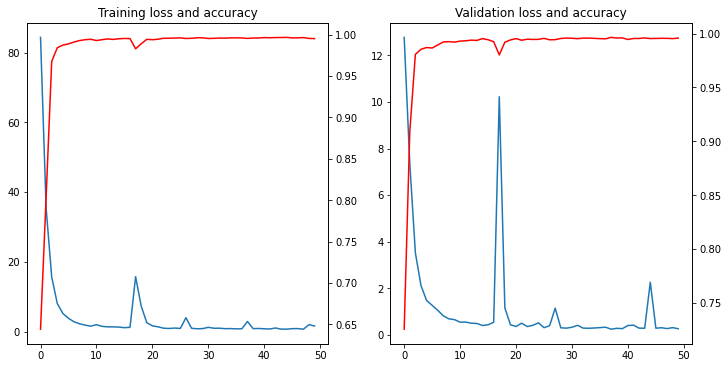

In [159]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 5))

axs[0].plot(np.arange(len(t_loss_v)), t_loss_v)
axs[0].twinx().plot(np.arange(len(t_acc_v)), t_acc_v,"r")
axs[0].set_title("Training loss and accuracy")
axs[0].set_yscale("linear")
axs[1].plot(np.arange(len(v_loss_v)), v_loss_v)
axs[1].twinx().plot(np.arange(len(v_acc_v)), v_acc_v,"r")
axs[1].set_title("Validation loss and accuracy")
axs[1].set_yscale("linear")

### Did it work?

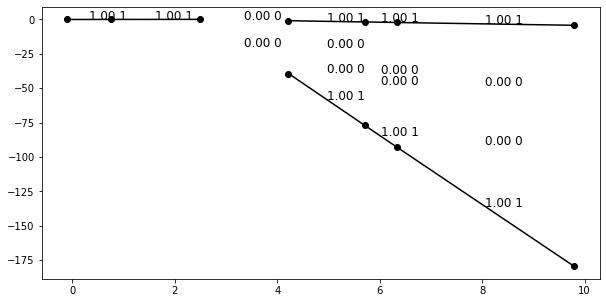

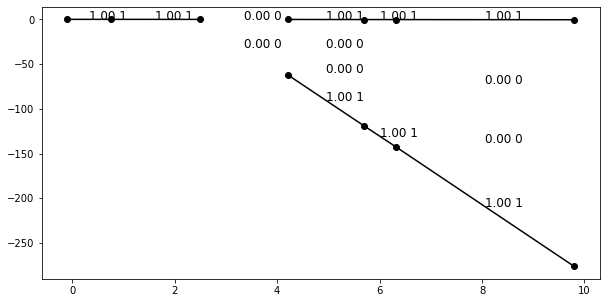

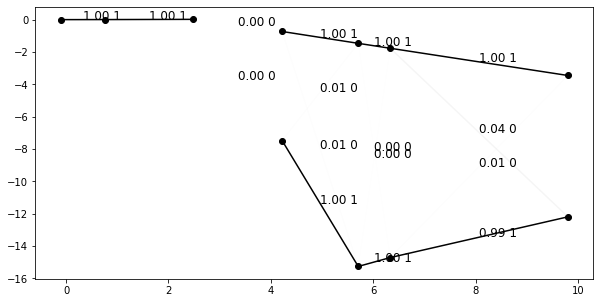

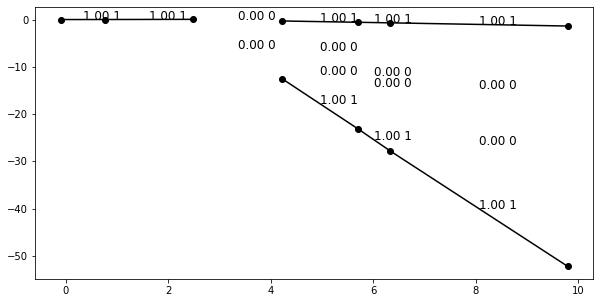

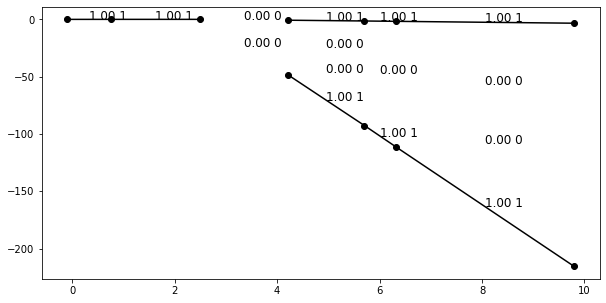

In [252]:
for i in range(0,5):
  data = train_loader.dataset[i].to(device)
  preds = torch.sigmoid(model(data)).to('cpu')
  plot_toy_classified(data.to('cpu'), preds, cut = 0.6)
  #plot_toy_graph(train_loader.dataset[2],0.2)

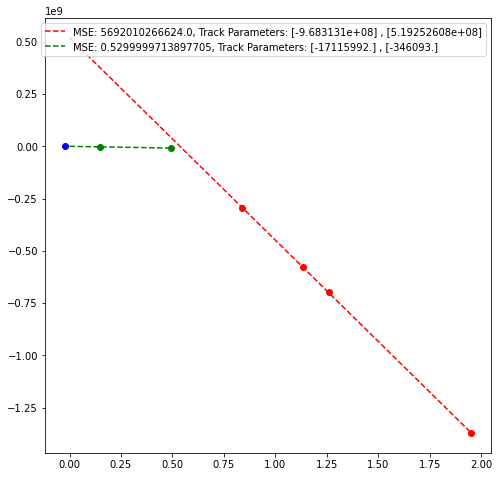

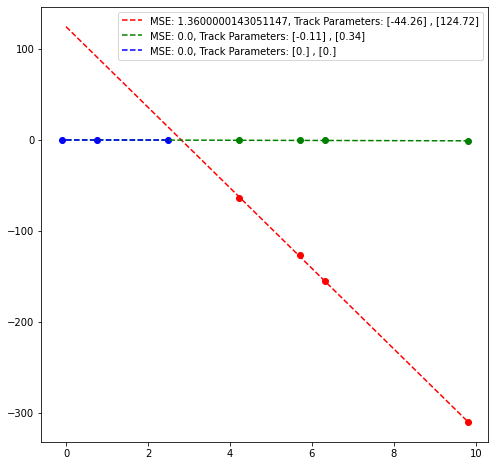

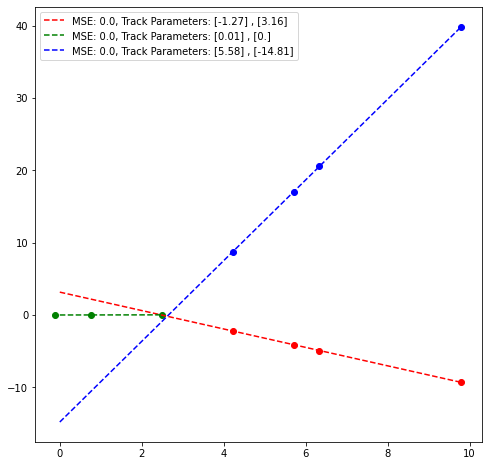

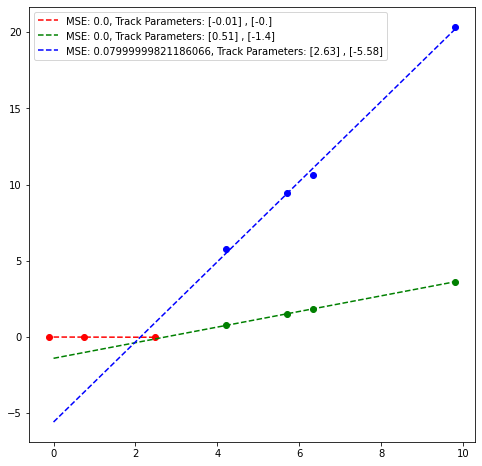

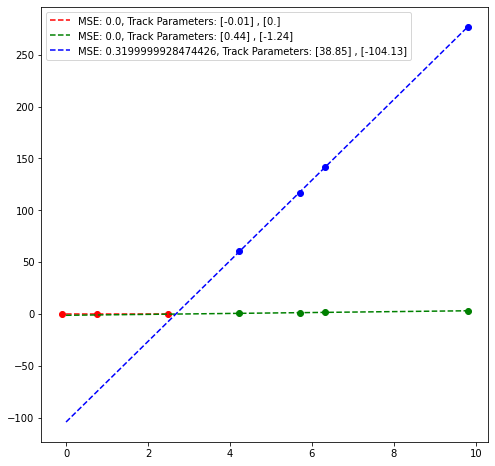

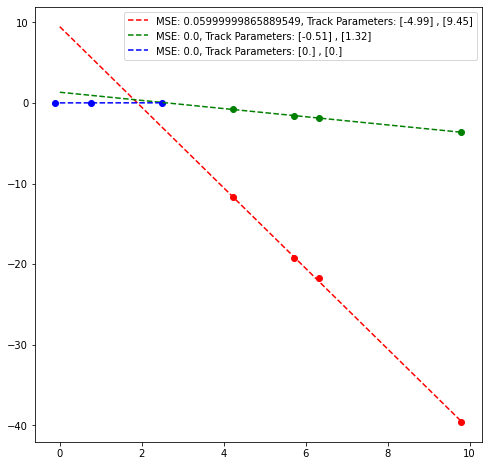

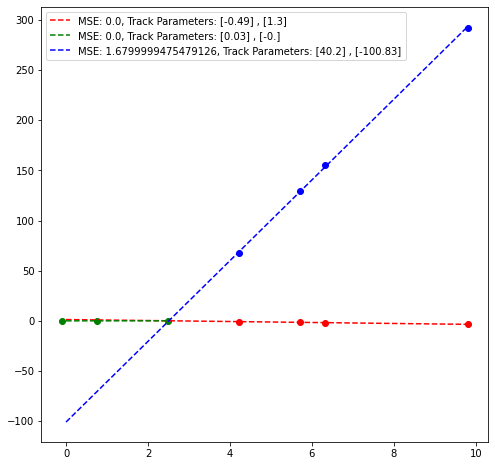

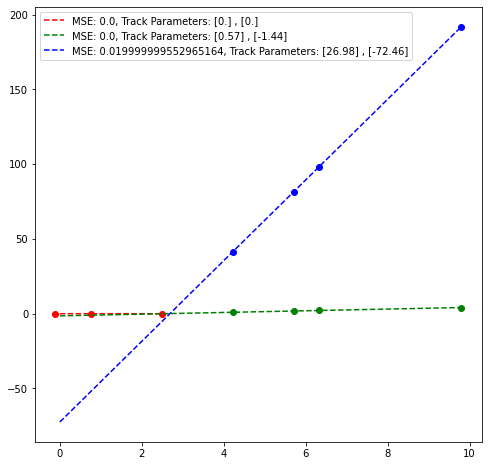

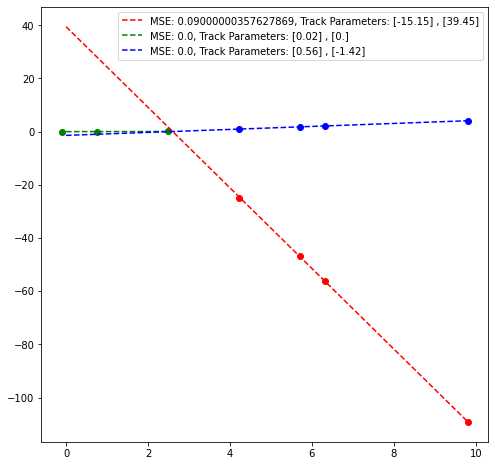

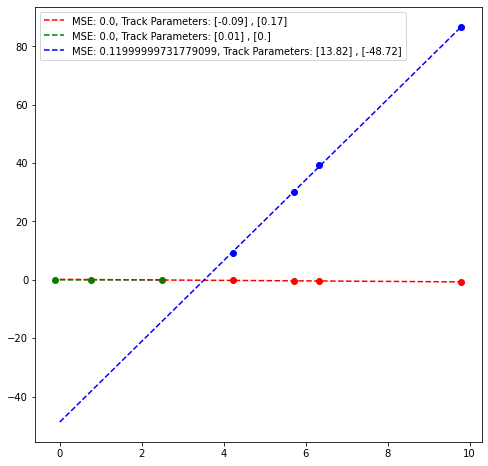

In [258]:

def finder(data,y,cut=0.5):
  x = data.x.detach().numpy()
  edge_index=data.edge_index.detach().numpy()
  node_identifier=np.zeros( list(x.shape)[0] )
  k=edge_index.shape[1]
  y=y.detach().tolist()
  is_connected=[]
  for i in range(k):
    if y[i]-cut>=0:
      is_connected.append( True )
    else:
      is_connected.append( False )

  for j in range(1,4):

    a=np.where( node_identifier==0 )

    try:
      min=np.min(x[a,1])
    except:
      print('oopsie')
      break
    idx=np.where(x[:,1]==min)
    try:
      idx=idx[0]
    except:
      pass
    
    neighbor = 1
    node_identifier[idx] = j
    
    
    while neighbor :

      neighbor = []
      try:
        idx=idx[-1]
      except:
        pass
      in_neighbor = [ int(edge_index[0,i]) for i in range(k) if int(edge_index[1,i])==idx if is_connected[i] 
                     if node_identifier[ edge_index[0,i] ] ==0  ]

      ot_neighbor = [ int(edge_index[1,i]) for i in range(k) if int(edge_index[0,i])==idx if is_connected[i] 
                     if node_identifier[ edge_index[1,i] ] ==0  ]
      neighbor = in_neighbor + ot_neighbor
      
      if len(neighbor)>0:
        for i in reversed( range( len(neighbor) ) ):
          if node_identifier[neighbor[i]] != 0 :
            del neighbor[i]
      

      if neighbor:
        idx=neighbor[0]

      node_identifier[neighbor] = j



  return node_identifier


from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import linear_model


def robust_fit(data,preds,estimator=linear_model.RANSACRegressor() ):
  node_lines = finder(data,preds)
  x,y=data.x[:,0],data.x[:,1]
  errors,models=[],[]
  parameters=[]
  for i in range(1,4):
    nodes=np.where(node_lines==i)
    if np.size(nodes)>1 :
      model=linear_model.RANSACRegressor()
      model.fit( x[nodes].reshape(-1, 1)  , y[nodes] )
      parameters.append([model.estimator_.coef_,model.predict(np.zeros(1).reshape(-1,1)) ]) 
      error = mean_squared_error( model.predict(x[nodes].reshape(-1, 1)), y[nodes] )
      error=np.round(error,2)
      errors.append(error)
      models.append(model)
    else  :
      models.append('N/A')
      errors.append('N/A')
      parameters.append('N/A')
  return [models,errors,parameters,node_lines]

def plot_classified_line(data,preds ):

  models,errors,parameters,node_lines=robust_fit(data,preds,linear_model.RANSACRegressor())
  x,y=data.x[:,0],data.x[:,1]
  colors={'1':'r','2':'g','3':'b' }
  plt.figure(figsize=(8,8))
  for i in range(1,4):
    nodes=np.where(node_lines==i)
    plt.plot(x[nodes],y[nodes],colors[str(i)] +'o' )
  for i in range(1,4):
    nodes=np.where(node_lines==i)
    if np.size(nodes)>1 :
      model=models[i-1]
      error=errors[i-1]
      x_guess=np.linspace(0,torch.max(x[nodes]),100)
      y_guess = model.predict( x_guess[:, np.newaxis] )
      plt.plot(x_guess,y_guess,'--'+colors[str(i)],label='MSE: {}, Track Parameters: {} , {}'. format( error , np.round(parameters[i-1][0],2),np.round(parameters[i-1][1],2)   )   )
  
  plt.legend()
  return parameters

for i in range(0,10):
  data = test_loader.dataset[i]
  preds=torch.sigmoid(model(data))
  #print(str(i)+' '+str(format(finder(data,y))))
  plot_classified_line(data,preds)


